In [1]:
from drlqap.reinforce import ReinforceAgent, Categorical2D
from drlqap.visualisation import draw_qap, draw_assignment_graph
from drlqap.qap import GraphAssignmentProblem, AssignmentGraph
from torch_geometric.utils import from_networkx
from drlqap import taskgenerators
import torch
from drlqap.evaluate import random_assignment
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from ipywidgets import interact
import networkx
from drlqap import nn
from pathlib import Path
from ipywidgets import interact
from drlqap import agent_configs
import drlqap.evaltools as tools

In [2]:
with open("testgraph.qap", "r") as f:
    qap = GraphAssignmentProblem.from_qaplib_string(f.read())

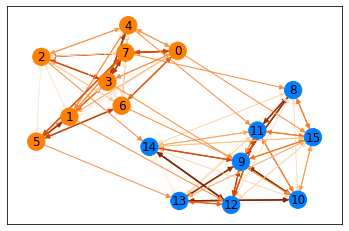

In [3]:
%matplotlib inline
draw_qap(qap, random_assignment(qap))

In [4]:
%matplotlib notebook
# enable interactive plots below

In [5]:
agent_folder = "../runs/layer_norm_randomgraphs/"
agents = tools.load_checkpoints(Path(agent_folder))

../runs/layer_norm_randomgraphs/checkpoint_0.pth
../runs/layer_norm_randomgraphs/checkpoint_1000.pth
../runs/layer_norm_randomgraphs/checkpoint_2000.pth
../runs/layer_norm_randomgraphs/checkpoint_3000.pth
../runs/layer_norm_randomgraphs/checkpoint_4000.pth
../runs/layer_norm_randomgraphs/checkpoint_5000.pth
../runs/layer_norm_randomgraphs/checkpoint_6000.pth
../runs/layer_norm_randomgraphs/checkpoint_7000.pth
../runs/layer_norm_randomgraphs/checkpoint_8000.pth
../runs/layer_norm_randomgraphs/checkpoint_9000.pth
../runs/layer_norm_randomgraphs/checkpoint_end.pth


In [6]:
final_agent = agents[-1]
print(final_agent.solve_and_learn(qap))
for param in final_agent.policy_net.parameters():
    if param.grad is not None:
        print(torch.norm(param.grad), param.shape)

(12.442406189528109, array([4, 6, 1, 3, 0, 5, 7, 2]))
tensor(7.4421e-09) torch.Size([64, 32])
tensor(8.1046e-10) torch.Size([64])
tensor(5.2174e-09) torch.Size([64, 64])
tensor(4.3150e-10) torch.Size([64])
tensor(6.1821e-09) torch.Size([64, 64])
tensor(3.6429e-10) torch.Size([64])
tensor(1.4340e-08) torch.Size([32, 64])
tensor(3.4650e-10) torch.Size([32])
tensor(4.3911e-09) torch.Size([32])
tensor(3.9338e-09) torch.Size([32])
tensor(1.3382e-08) torch.Size([64, 64])
tensor(1.5334e-09) torch.Size([64])
tensor(1.5515e-08) torch.Size([64, 64])
tensor(1.0828e-09) torch.Size([64])
tensor(1.8454e-08) torch.Size([64, 64])
tensor(7.8212e-10) torch.Size([64])
tensor(4.9779e-08) torch.Size([1, 64])
tensor(1.5081e-09) torch.Size([1])


<IPython.core.display.Javascript object>


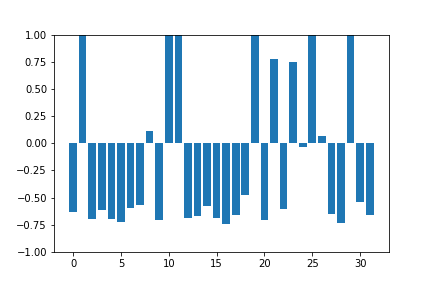

interactive(children=(Dropdown(description='i', options=(0, 1, 2, 3, 4, 5, 6, 7), value=0), IntSlider(value=5,…

<IPython.core.display.Javascript object>


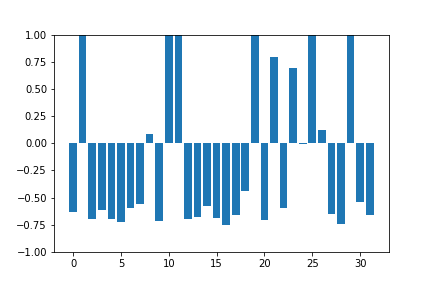

interactive(children=(Dropdown(description='i', options=(0, 1, 2, 3, 4, 5, 6, 7), value=0), IntSlider(value=5,…

In [19]:
%matplotlib notebook
# Node embeddings
start_graph_a_by_epoch = []
start_graph_b_by_epoch = []
start_net_states = []
for agent in agents:
    net = agent.policy_net
    start_graph_a_by_epoch.append(net.transform_initial_graph(qap.graph_source))
    start_graph_b_by_epoch.append(net.transform_initial_graph(qap.graph_target))
    start_net_states.append(net.initial_step(qap))
node_embedding_a_by_epoch = [data.x for data in start_graph_a_by_epoch]
node_embedding_b_by_epoch = [data.x for data in start_graph_b_by_epoch]
tools.interactive_embeddings_series(node_embedding_a_by_epoch)
tools.interactive_embeddings_series(node_embedding_b_by_epoch)

<IPython.core.display.Javascript object>


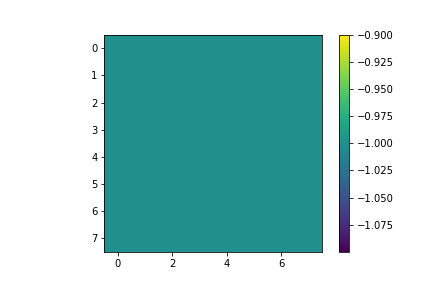

interactive(children=(IntSlider(value=5, description='i', max=10), Output()), _dom_classes=('widget-interact',…

In [20]:
# Probability matrices
all_nodes = list(qap.graph_source.nodes)
probs_by_epoch = torch.stack([
    agent.policy_net.compute_link_probabilities(
        start_net_states[i],
        all_nodes,
        all_nodes
    ) for i, agent in enumerate(agents)
])

tools.interactive_matrix_series(probs_by_epoch)#, vmin=torch.min(probs_by_epoch), vmax=torch.max(probs_by_epoch))

<IPython.core.display.Javascript object>


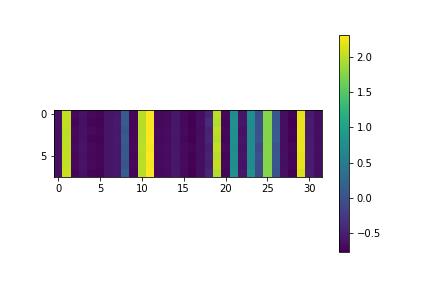

interactive(children=(IntSlider(value=5, description='i', max=10), Output()), _dom_classes=('widget-interact',…

<IPython.core.display.Javascript object>


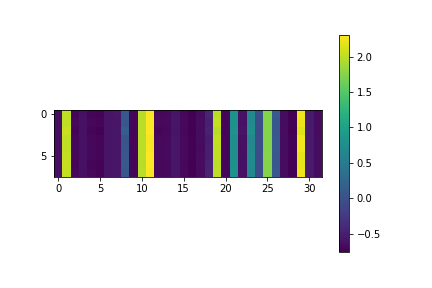

interactive(children=(IntSlider(value=5, description='i', max=10), Output()), _dom_classes=('widget-interact',…

In [21]:
tools.interactive_matrix_series(node_embedding_a_by_epoch)
tools.interactive_matrix_series(node_embedding_b_by_epoch)

In [10]:
def print_parameter_gradients(x):
    agent.optimizer.zero_grad(set_to_none=True)
    x.backward(retain_graph=True)
    for param in agent.networks.parameters():
        if param.grad is not None:
            print(torch.norm(param.grad))

In [11]:
#print_parameter_gradients(probabilities[5,3])

In [12]:
#agent.link_freeze_net(torch.cat((embeddings_a[0], embeddings_b[1])))

In [13]:
baselines = [agent.baseline.mean() for agent in agents]

<IPython.core.display.Javascript object>


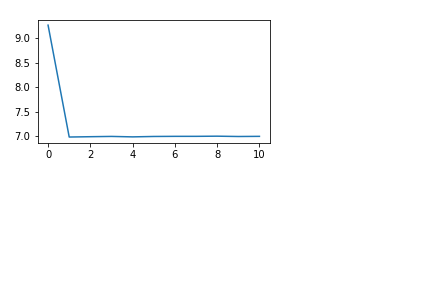

In [14]:
plt.figure()
plt.plot(baselines)
plt.show()

In [15]:
def compute_assignment_matrix(agent):
    n = qap.size
    counts = np.zeros((n,n))
    sums = np.zeros((n,n))
    
    samples = 200
    for _ in range(samples):
        value, assignment = agent.solve(qap)
        for i,j in enumerate(assignment):
            counts[i,j] += 1
            sums[i,j] += value
    
    return sums / counts # divide by zero -> nan -> don't show

In [16]:
assignment_matrices = [
    compute_assignment_matrix(agent)
    for agent in agents
]

/tmp/ipykernel_11809/63198837.py:13: RuntimeWarning: invalid value encountered in true_divide
  return sums / counts # divide by zero -> nan -> don't show


In [17]:
assignment_matrices = np.array(assignment_matrices)

<IPython.core.display.Javascript object>


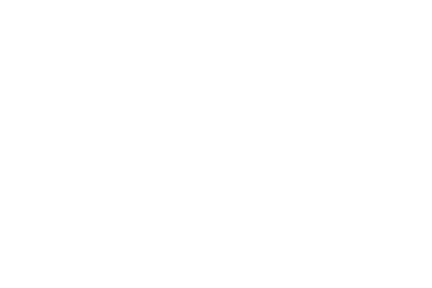

interactive(children=(IntSlider(value=5, description='i', max=10), Output()), _dom_classes=('widget-interact',…

In [18]:
tools.interactive_matrix_series(
    assignment_matrices, 
    cmap=plt.get_cmap("viridis_r"), 
    vmin=np.nanmin(assignment_matrices), 
    vmax=np.nanmax(assignment_matrices)
)